# How to use lightkurve for asteroseismology

Asteroseismology is the study of stellar oscillations. To see them, we usually want to transfer from the *time domain* that light curves are in to the *frequency domain*. We can do that with periodograms such as Fourier Transforms or Lomb-Scargle Periodograms. `lightkurve` has built in routines for working with data in the *frequency domain* which are useful for asteroseismologists. 

Below we demonstrate some of the new functionalities in `lightkurve` and how to use them for asteroseismology.

In [1]:
from lightkurve import KeplerTargetPixelFile
import matplotlib.pyplot as plt
import numpy as np
from lightkurve import log
log.setLevel('ERROR')

As an example, we can use a giant star from Campaign 5. You can read more about asteroseismology with giants in K2 in Stello et al 2015 [here](https://arxiv.org/pdf/1610.03060.pdf). 

First we'll use `from_archive` to download the Target Pixel File for the target.

In [2]:
ID = 211416749
tpf = KeplerTargetPixelFile.from_archive(ID, campaign=5, cadence='short')

Let's plot the target below to see if the aperture is centered. We're plotting in 'log' scale here so that we can see the wings of the PSF.

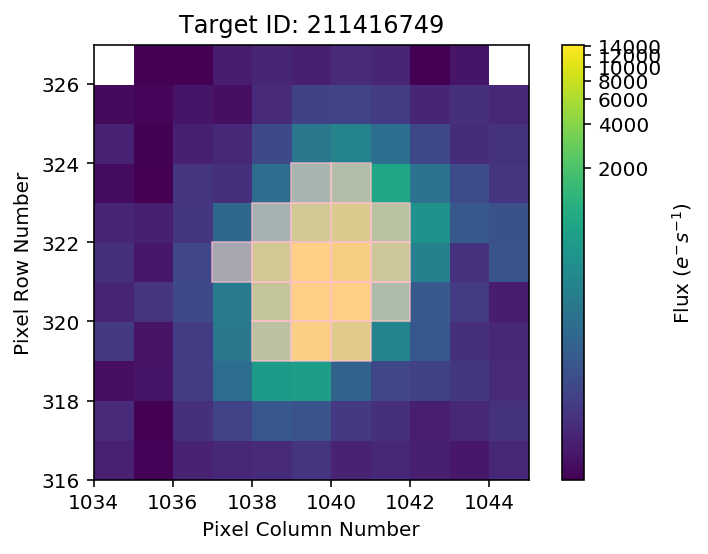

In [3]:
tpf.plot(scale='log', aperture_mask=tpf.pipeline_mask)

We can now create a `LightCurve` using Simple Aperture Photometry with the `to_lightcurve` method. We can then normalize, remove NaN values and remove outliers in one easy line. We can also use the new `fill_gaps` method to fill in any gaps there are in our data using linear interpolation of the nearest neighbours. This creates an almost perfectly sampled time array with no gaps.

In [4]:
lc = tpf.to_lightcurve()
lc = lc.normalize().remove_nans().remove_outliers().fill_gaps()

We can plot our light curve easily with the `plot` method.

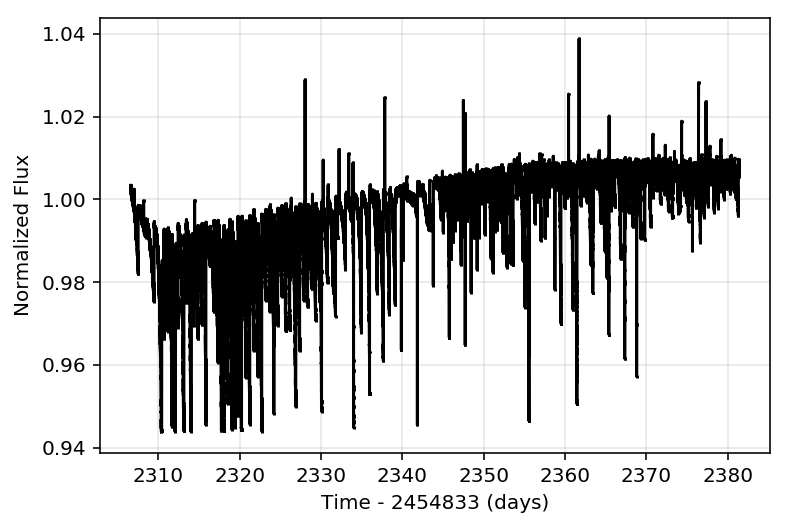

In [5]:
lc.plot()

Let's take a look at the periodogram for this light curve. You can create a `periodogram` object using `lc.periodogram()`. This can be passed any array of frequencies that the user wants, but by default will create an array of frequency for you. (Frequency values range from 1$\mu Hz$ to the nyquist frequency of the data, with $N/2$ points, where $N$ is the number of time points in the light curve.)

In [6]:
p = lc.periodogram()

With this new periodogram object we can now plot the power spectrum of the data. Let's do that now!

(0, 400)

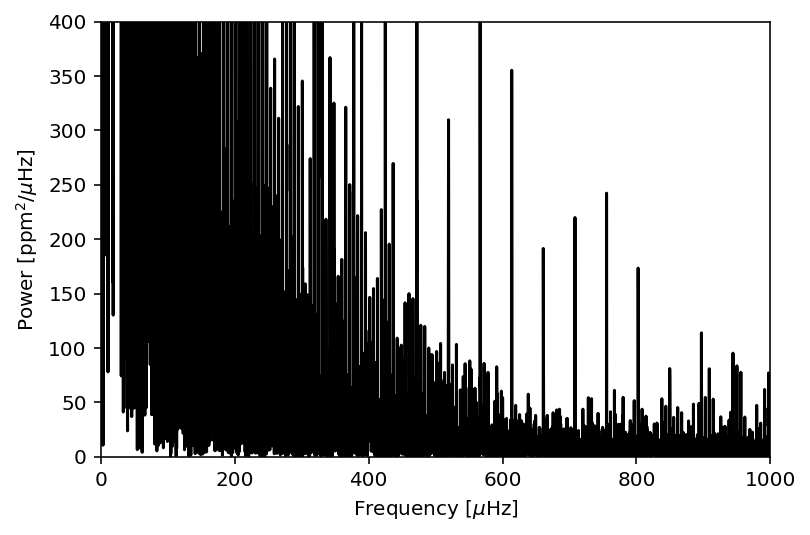

In [7]:
ax = p.plot(c='k')

ax.set_xlim(0, 1000)
ax.set_ylim(0, 400)

Unfortunately there is some ringing going on...there is a periodicity in the data due to the K2 motion. But we can apply our own Self Flat Fielding (SFF) correction to the light curve to remove this. Below we correct with SFF using the default `correct` function, with `windows=10`. Windows changes the number of 'chunks' we split the light curve into before detrending. (You can read more about SFF in our other tutorials.) 

In [8]:
lc =  tpf.to_lightcurve().normalize().remove_nans().remove_outliers()
clc = lc.correct(windows=10).remove_outliers().fill_gaps()

100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


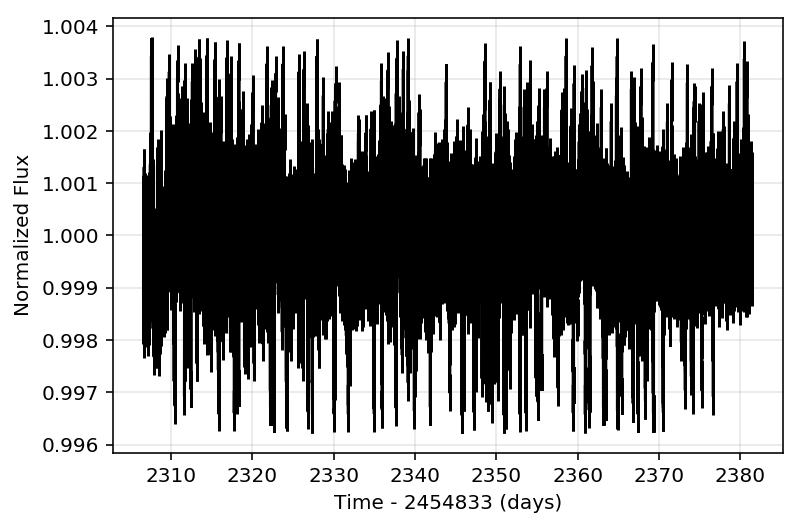

In [9]:
clc.plot()

Our new, corrected lightcurve looks much flatter and has a much smaller CDPP. Let's try plotting the periodogram again.

(0, 50)

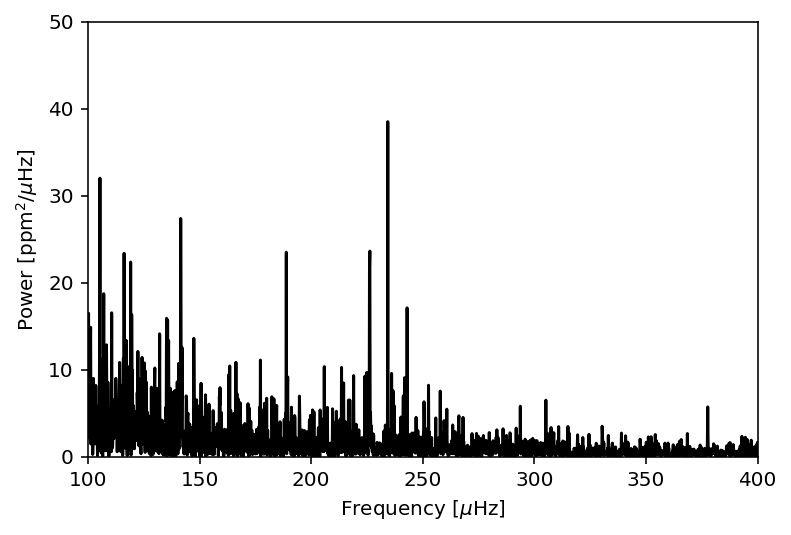

In [10]:
p_clean = clc.periodogram()
ax = p_clean.plot(c='k')

ax.set_xlim(100, 400)
ax.set_ylim(0, 50)

This is much better! Now we can see the oscillation modes of the target!

We can even find out what effect our detrending parameters have on our target. Below we change the detrending windows from $w=2\; ... \; 10$ and plot the periodogram in each case. We can see different detrending parameters has an effect on each of the modes.

100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


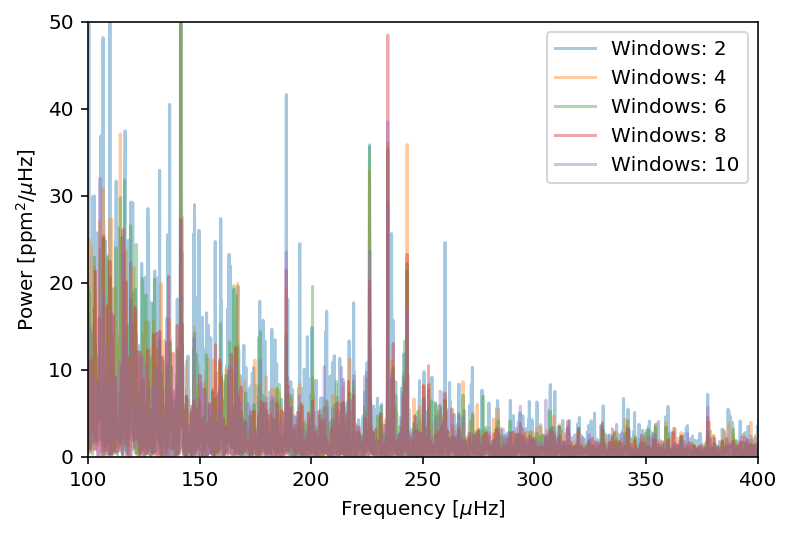

In [11]:
# Create a window to plot into
fig, ax = plt.subplots(1)

# Loop over several windows
for windows in np.arange(2, 12, 2):
    # Create the light curve
    lc =  tpf.to_lightcurve().normalize().remove_nans().remove_outliers()
    clc = lc.correct(windows=windows).remove_outliers().fill_gaps()
    # Create the periodogram
    p_clean = clc.periodogram()
    # Plot the periodogram
    p_clean.plot(ax=ax, alpha=0.4, label='Windows: {}'.format(windows))

ax.set_xlim(100, 400)
ax.set_ylim(0, 50)
ax.legend()

We can also easily change the aperture size. If the aperture is too small, increasing the aperture size should allow us to include more of the target flux. If there is a contaminant nearby, decreasing the aperture may increase our singal to noise.

Below we create a new aperture for the target. In this case we've used an aperture where pixels have a value greater than the 70th percentile.

In [12]:
aper = np.nanmedian(tpf.flux, axis=0) > np.nanpercentile(np.nanmedian(tpf.flux, axis=0), 70)

/Users/ch/miniconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:907: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/Users/ch/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


We can plot up our new aperture against the pipeline aperture for comparison.

Text(0.5,1,'Larger Aperture')

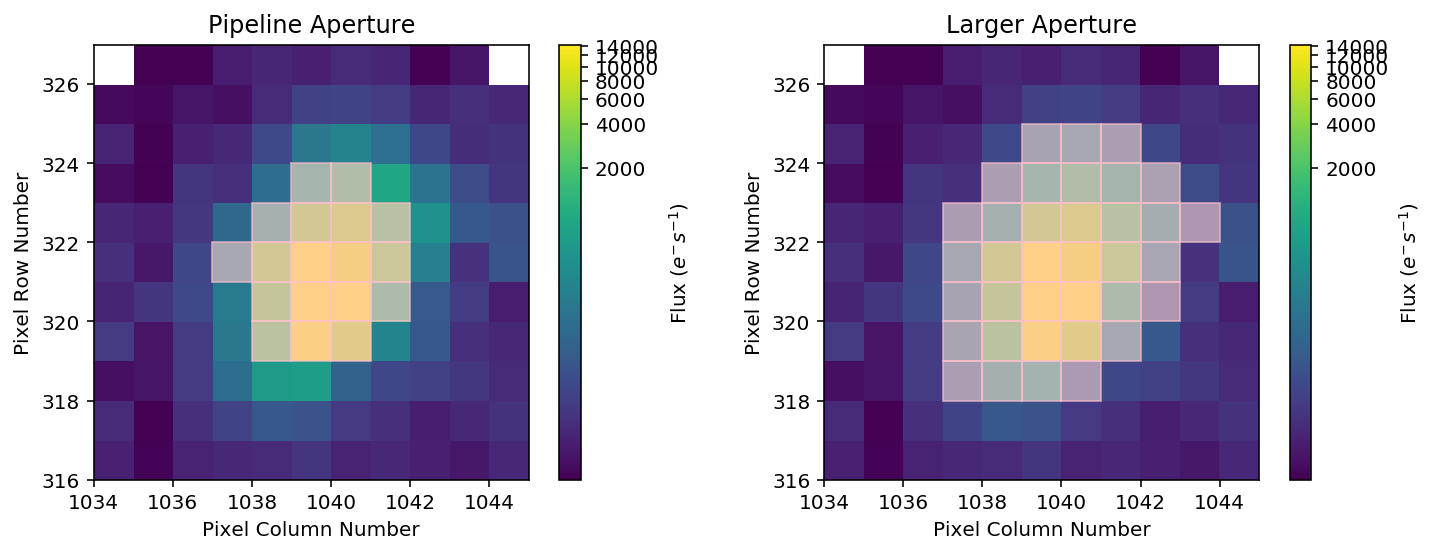

In [13]:
# Two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot pipeline aperture mask
tpf.plot(axs[0], scale='log', aperture_mask=tpf.pipeline_mask)
axs[0].set_title('Pipeline Aperture')

# Plot larger aperture mask
tpf.plot(axs[1], scale='log', aperture_mask=aper)
axs[1].set_title('Larger Aperture')

Now let's create our two light curves, one with the pipeline aperture and one with the new aperture. 

`tpf.to_lightcurve()` creates our SAP flux with the pipeline aperture as a default. To use a new aperture we simple use `tpf.to_lightcurve(NEW_APERTURE)`.

In [14]:
# Create the light curve with the pipelien aperture.
lc_pipeline = tpf.to_lightcurve().normalize().remove_nans().remove_outliers()
lc_pipeline = lc_pipeline.correct(windows=10).remove_outliers().fill_gaps()

# Create a light curve with a slightly larger aperture 
lc_larger_aperture = tpf.to_lightcurve(aper).normalize().remove_nans().remove_outliers()
lc_larger_aperture = lc_larger_aperture.correct(windows=10).remove_outliers().fill_gaps()

100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


When we plot these two light curves we can see that the larger aperture is much less noisy.

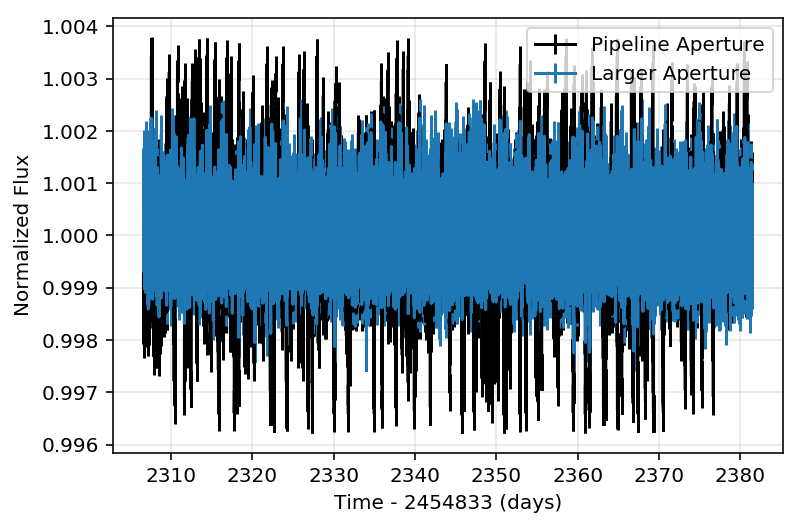

In [15]:
# Create subplots to plot into
fig, ax = plt.subplots()

#Plot the pipeline and large aperture light curves
lc_pipeline.plot(ax=ax, label='Pipeline Aperture')
lc_larger_aperture.plot(ax=ax, label='Larger Aperture')

Finally, when we plot the periodogram we can see we've increased the signal to noise ratio of our stellar oscillations.

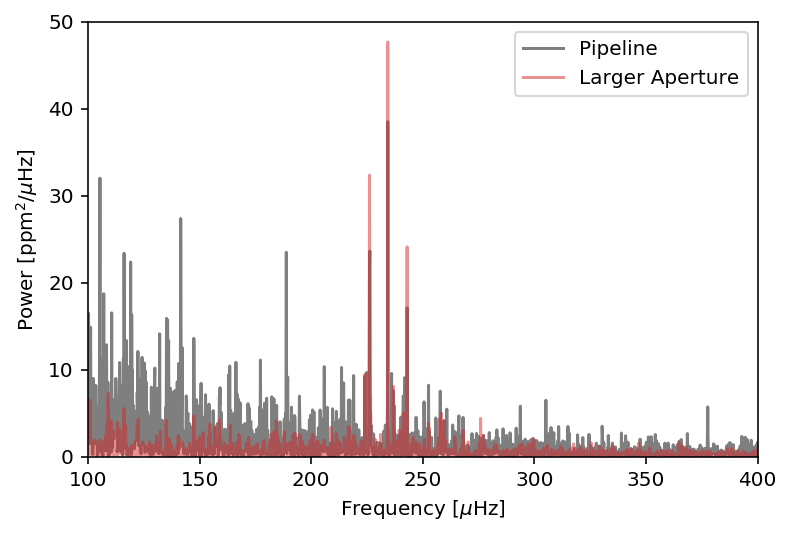

In [16]:
# Create the periodograms
p_pipeline = lc_pipeline.periodogram()
p_larger_aperture = lc_larger_aperture.periodogram()

# Create subplots to plot into
fig, ax = plt.subplots()
# Plot the periodograms
p_pipeline.plot(ax=ax, c='k', alpha=0.5, label='Pipeline')
p_larger_aperture.plot(ax=ax, c='C3', alpha=0.5, label='Larger Aperture')


ax.set_xlim(100, 400)
ax.set_ylim(0, 50)
ax.legend();

Finally, this target was actually observed twice by K2, once in April 2015 in Campaign 5 and once in December 2017 in Campaign 16. We can get both of these data sets and compare the results. 

In [17]:
# Download the C16 TPF
tpf_c16 = KeplerTargetPixelFile.from_archive(ID, campaign=16, cadence='short')

# Create a new "large" aperture where flux is greater than the 70th percentile.
aper = np.nanmedian(tpf_c16.flux, axis=0) > np.nanpercentile(np.nanmedian(tpf_c16.flux, axis=0), 70)

# Create a new light curve for C16
lc_c16 = tpf_c16.to_lightcurve('all').normalize().remove_nans().remove_outliers()
lc_c16 = lc_c16.correct(windows=10).remove_outliers().fill_gaps()

/Users/ch/miniconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:907: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/Users/ch/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


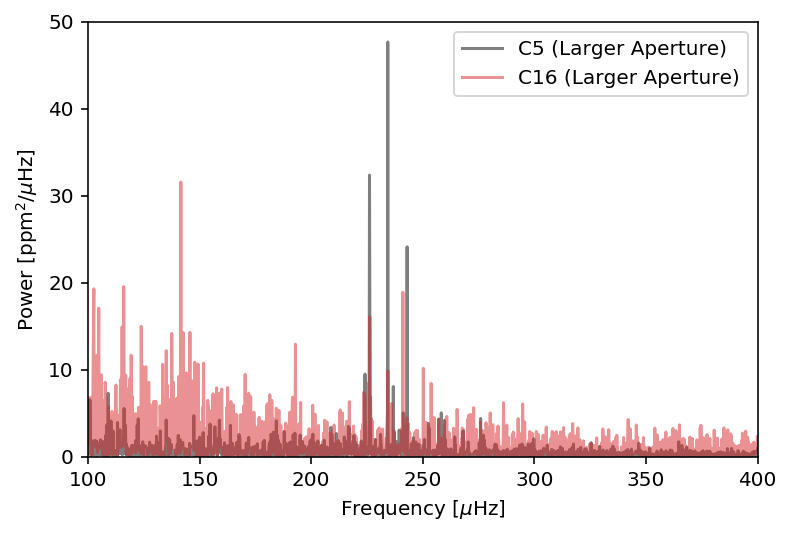

In [18]:
# Create the C16 periodogram
p_c16_larger_aperture = lc_c16.periodogram()

# Create subplots to plot into
fig, ax = plt.subplots()
p_larger_aperture.plot(ax=ax, c='k', alpha=0.5, label='C5 (Larger Aperture)')
p_c16_larger_aperture.plot(ax=ax, c='C3', alpha=0.5, label='C16 (Larger Aperture)')

ax.set_xlim(100, 400)
ax.set_ylim(0, 50)
ax.legend()

It looks like the signal to noise in the C16 data set is reduced for this target. This may be due to the target being closer to the edge of the detector. Perhaps better detrending parameters and aperture choices will increase the signal to noise!